In [162]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Dense
from keras.models import Model

In [3]:
df = pd.read_csv('natural_gas.csv')
df.head()

,Date,Open,High,Low,Close,Volume,Currency
0,2000-01-04,2.130,2.200,2.130,2.176,30152,USD
1,2000-01-05,2.180,2.200,2.125,2.168,27946,USD
2,2000-01-06,2.165,2.220,2.135,2.196,29071,USD
3,2000-01-07,2.195,2.230,2.155,2.173,28455,USD
4,2000-01-10,2.180,2.255,2.165,2.216,28916,USD


In [18]:
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
df.Currency.unique()

array(['USD'], dtype=object)

The Currency feature is dropped, since all currencies are USD.

In [42]:
df.drop('Currency', errors='ignore', inplace=True, axis=1)
df.head(), df.shape

(        Date   Open   High    Low  Close  Volume
 0 2000-01-04  2.130  2.200  2.130  2.176   30152
 1 2000-01-05  2.180  2.200  2.125  2.168   27946
 2 2000-01-06  2.165  2.220  2.135  2.196   29071
 3 2000-01-07  2.195  2.230  2.155  2.173   28455
 4 2000-01-10  2.180  2.255  2.165  2.216   28916,
 (5708, 6))

# Feature Engineering
I simply add features for a "Change" feature which is the change from the previous day's high price and a "Change Sign" feature which determines if the change was positive, negative or zero.

In [89]:
current_price = df['High'].values[1:]
previous_price = df['High'].values[:-1]
delta =  [current_price - previous_price]
delta = np.insert(delta, 0,0)
delta_sign = [d/np.abs(d) if d != 0 else d for d in delta]
df['Change'] = delta
df['Change Sign'] = delta_sign

df.head()

,Date,Open,High,Low,Close,Volume,Change,Change Sign
0,2000-01-04,2.130,2.200,2.130,2.176,30152,0.000,0.0
1,2000-01-05,2.180,2.200,2.125,2.168,27946,0.000,0.0
2,2000-01-06,2.165,2.220,2.135,2.196,29071,0.020,1.0
3,2000-01-07,2.195,2.230,2.155,2.173,28455,0.010,1.0
4,2000-01-10,2.180,2.255,2.165,2.216,28916,0.025,1.0


# Data cleaning

In [90]:
nan_features = []
for feature in df.columns:
    if df[df[feature].isna()].shape[0] > 0:
        nan_features.append(feature)
if len(nan_features) > 0:
    print('NaN values in the following columns:')
    print(nan_features)
else:
    print('No NaN features found.')

No NaN features found.


# Exploratory Data Analysis

## Price and Volume Changes Over Time

In [106]:
'''
Calculates the rolling average over the past avg_length days
Takes in the feature for which to calculate the rolling average and the number of days to use as a subset to calculate an average
Returns the rolling average for the feature.
'''
def make_rolling_average(feature, avg_length=30):
    values = df[feature].values
    rolling_average = []
    for i in range(values.shape[0]):
        if i >= avg_length:
            # Average over the previous avg_length values through the current value
            rolling_average.append(np.average(values[i-avg_length: i+1]))
        # If there are not 30 previous values, average over all previous values
        else:
            rolling_average.append(np.average(values[:i+1]))
    return rolling_average

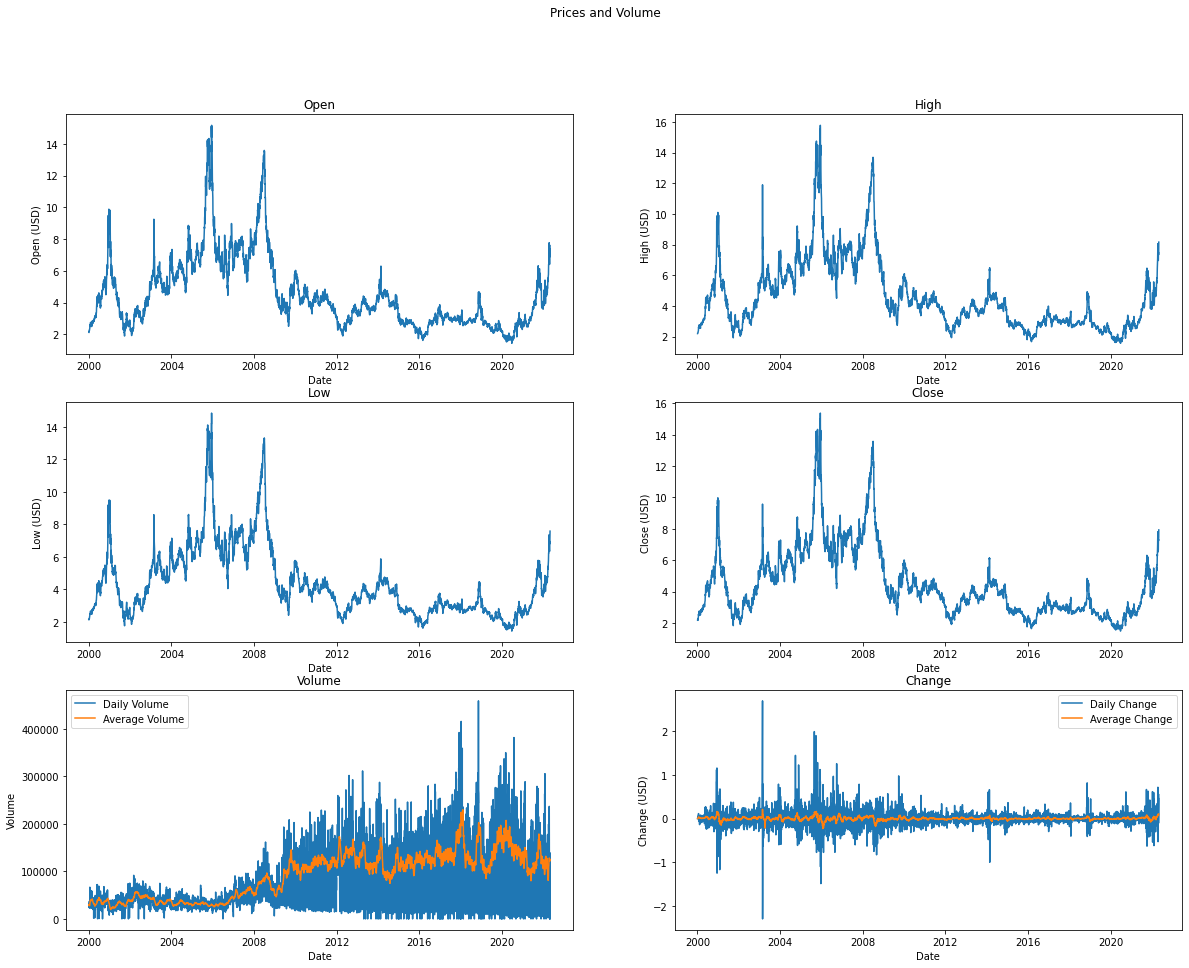

In [111]:
fig, axes = plt.subplots(3,2, figsize=(20,15))
axes = axes.flatten()
for i, feature in enumerate(df.columns[1:-1]):
    sns.lineplot(data=df, x='Date', y=feature, ax=axes[i])
    axes[i].set_title(feature)
    if feature != 'Volume':
        axes[i].set_ylabel(f'{feature} (USD)')
    if feature == 'Volume' or feature == 'Change':
        sns.lineplot(data=df, x='Date', y=make_rolling_average(feature), ax=axes[i])
        axes[i].legend(labels=[f'Daily {feature}', f'Average {feature}'])
plt.suptitle('Prices and Volume')
plt.show()

### Sign of Change in High Prices Over Time

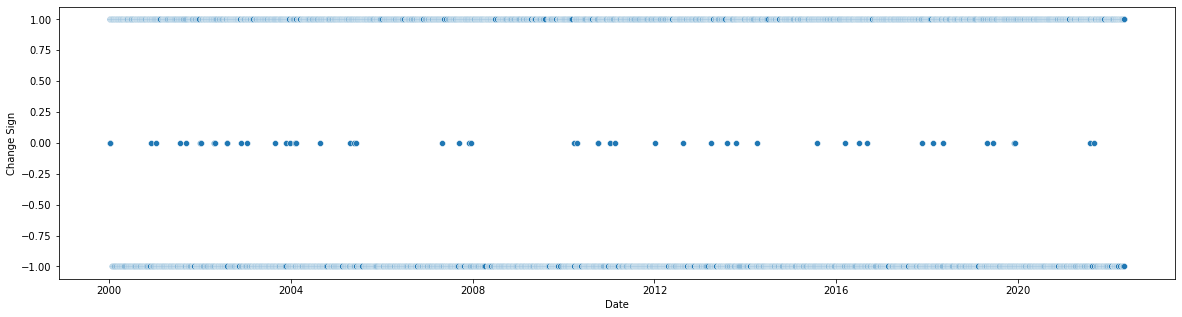

In [99]:
plt.figure(figsize=(20,5))
sns.scatterplot(data=df, x='Date', y='Change Sign')
plt.show()

All that can really be gleaned from the above plot is that prices tend to go either up or down, rather than stay the same. This is unsurprising.

## Price, High Price Change and Volume Distributions

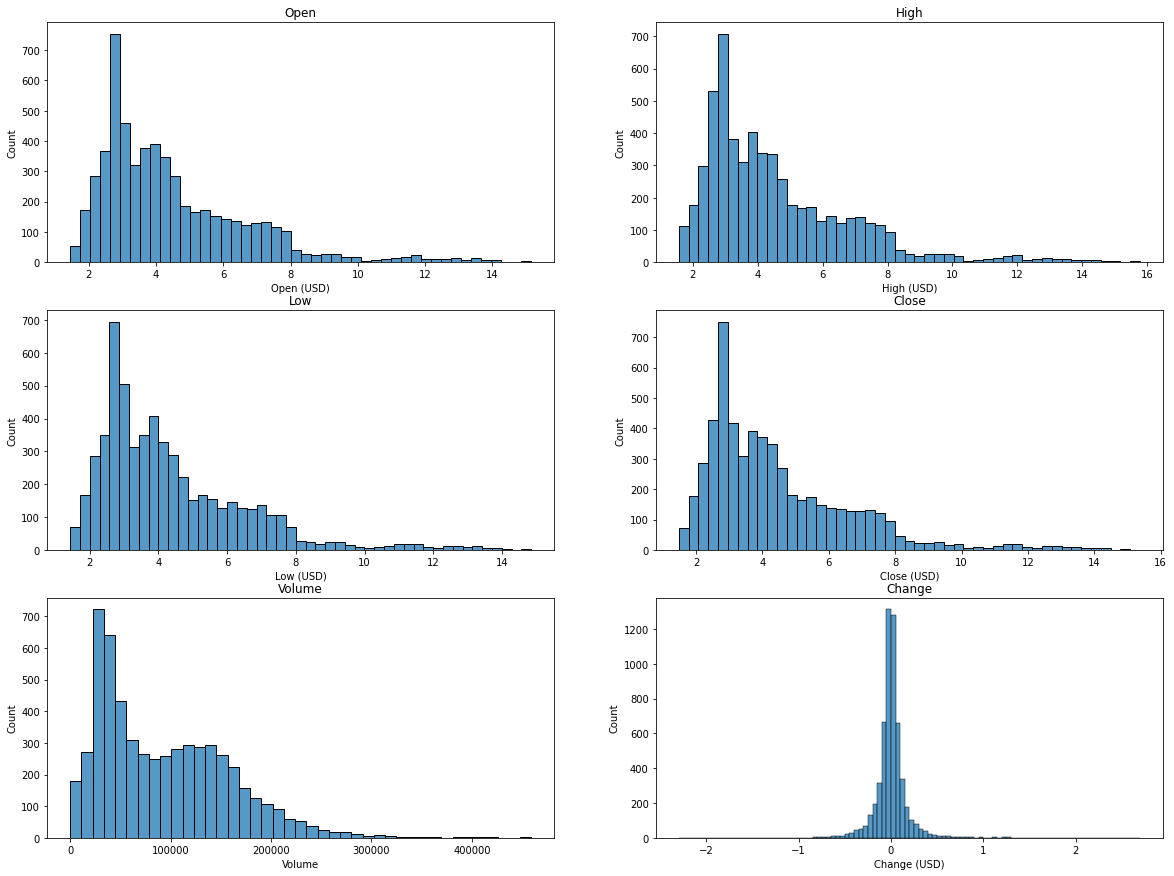

In [124]:
fig, axes = plt.subplots(3,2, figsize=(20,15))
axes = axes.flatten()
for i, feature in enumerate(df.columns[1:-1]):
    axes[i].set_title(feature)
    if feature != 'Volume':
        axes[i].set_xlabel(f'{feature} (USD)')

    if feature == 'Change':
        sns.histplot(data=df,x=feature, ax=axes[i], bins=100)
    else:
        sns.histplot(data=df,x=feature, ax=axes[i])

In [137]:
change_std = df['Change'].std()
change_mean = df['Change'].mean()
print(f'The standard deviation for the daily change distribution is ${np.round(change_std, decimals=3)}, and its mean is {np.round(change_mean, decimals=3)}.')

The standard deviation for the daily change distribution is $0.179, and its mean is 0.001.


None of the distributions appear to be normal. None are symmetrical, with the exception of possibly the daily change in price. None of this is surprising. All of the distributions are similarly shaped. Given that the change in USD are mostly under about $0.50, this is an unsurprising result with respect to prices. However the daily volume, while not distributed identically to the prices, also peaks shortly before zero, followed by a long tail, similarly to the price distributions.

## Correlations

<AxesSubplot:>

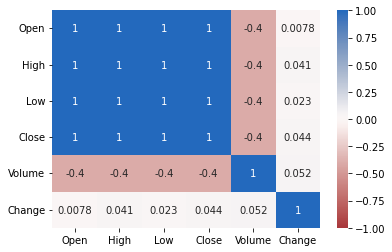

In [154]:
corr = df[df.columns[1:-1]].corr()
div_palette = sns.color_palette("vlag_r", as_cmap=True)
sns.heatmap(data=corr, annot=True, vmin=-1, vmax=1, cmap=div_palette)

Here, there are more expected results: prices correlate highly with each other. The volume correlates negatively with prices. Change in price does not correlate much at all with anything else.

## Change in Sign

### Distribution

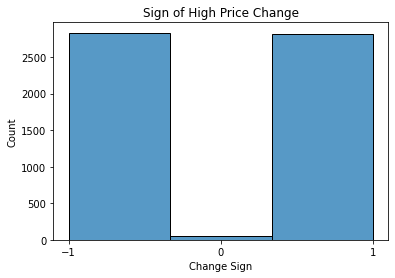

There are 2822 price increases, accounting for 49.44% of price changes
There are 2833 price decreases, accounting for 49.63% of price changes
There are 53 price decreases, accounting for 0.93% of price changes


In [148]:
positive_changes = df[df['Change Sign'] == 1].shape[0]
negative_changes = df[df['Change Sign'] == -1].shape[0]
no_changes = df[df['Change Sign'] == 0].shape[0]
total_changes = df.shape[0]

sns.histplot(data=df, x='Change Sign', bins=3)
plt.title('Sign of High Price Change')
plt.xticks([-1,0,1])
plt.show()

print(f'There are {positive_changes} price increases, accounting for {np.round(100* positive_changes/total_changes, decimals=2)}% of price changes')
print(f'There are {negative_changes} price decreases, accounting for {np.round(100* negative_changes/total_changes, decimals=2)}% of price changes')
print(f'There are {no_changes} price decreases, accounting for {np.round(100* no_changes/total_changes, decimals=2)}% of price changes')

### Direction of Change with Respect to Other Features

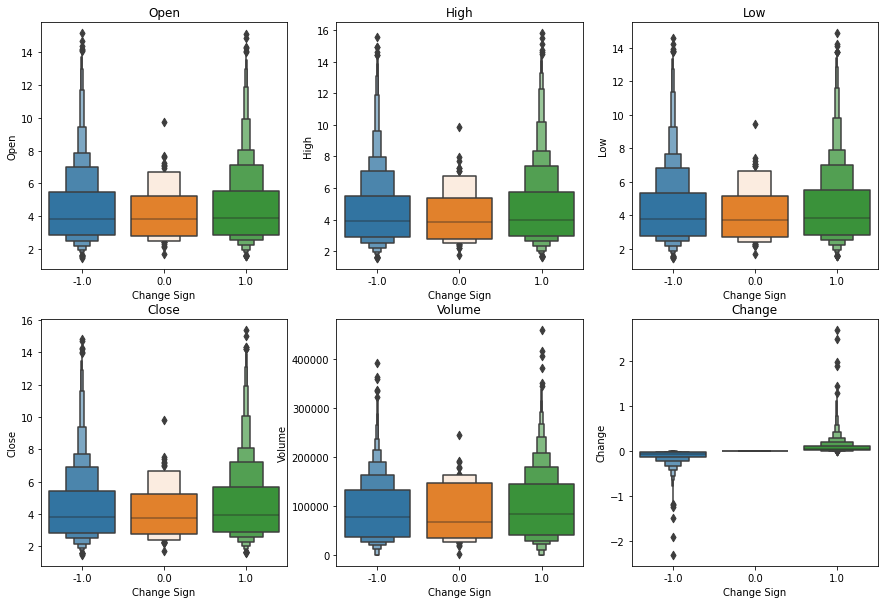

In [161]:
fig, axes = plt.subplots(2,3, figsize=(15,10))
axes = axes.flatten()
for i, feature in enumerate(df.columns[1:-1]):
    sns.boxenplot(data=df, x='Change Sign', y=feature, ax=axes[i])
    axes[i].set_title(feature)

Similarly to the change in price itself, there does not seem to be much relationship between prices, volumes and the direction of the price change. The exception is a relation with the change in price itself, which is, of course, trivial.

# Price Prediction
Prices are predicted using an LSTM

## Split the data